In [ ]:
# !pip install pydicom

# Image Classification with CNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection importRandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score


2023-04-16 17:51:29.051711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 17:51:33.015097: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 17:51:44.134097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-16 17:51:44.134744: W tensorflow/strea

### Load Dataset

In [ ]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 13 s, sys: 950 ms, total: 14 s
Wall time: 14 s


In [ ]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [ ]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [ ]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [ ]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [ ]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [ ]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [ ]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [ ]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [ ]:
random_state = 1234

In [ ]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [ ]:
X= resized_images_mini
y = y_mini

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape

(4480, 224, 224, 1)

In [ ]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    return X_train_augm, y_train_augm


2023-04-16 17:54:14.783987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-16 17:54:14.797954: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 17:54:14.798128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1866c7a4bea4): /proc/driver/nvidia/version does not exist
2023-04-16 17:54:14.872886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [ ]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

In [ ]:
# Run the function
X_train_augm, y_train_augm = preprocess_augm(X_train, y_train)

In [ ]:
num_augmented_images = 200
X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=num_augmented_images)

In [ ]:
# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

In [ ]:
X_train.shape

(4680, 50176)

## Build Model

In [ ]:
param_grid = {
    'max_depth': [1, 3, 6, 9, 12], 
    'min_samples_split': np.linspace(2, .1 * len(X_train), 10).astype(int),
    'max_features': np.linspace(.1, 1, 10),
    'criterion': ['gini', 'entropy'],
}


In [ ]:
dtc = DecisionTreeClassifier(
    random_state=random_state
)

In [ ]:
X_train.shape

(4680, 50176)

In [ ]:
y_train.shape

(4680,)

In [ ]:
grid_search = RandomizedSearchCV(
    dtc, 
    param_distributions=param_dist, 
    cv=StratifiedGroupKFold(5),
    scoring='f1',
    n_jobs=10,
    verbose=20,
    n_iter=20,
    return_train_score=True,
)

grid_search.fit(X_train, y_train, groups=groups)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 4/5; 3/500] START criterion=entropy, max_depth=3, max_features=0.8, min_samples_split=312
[CV 4/5; 3/500] END criterion=entropy, max_depth=3, max_features=0.8, min_samples_split=312;, score=(train=0.604, test=0.597) total time= 1.0min
[CV 5/5; 8/500] START criterion=gini, max_depth=3, max_features=0.1, min_samples_split=53
[CV 5/5; 8/500] END criterion=gini, max_depth=3, max_features=0.1, min_samples_split=53;, score=(train=0.609, test=0.630) total time=   6.0s
[CV 1/5; 10/500] START criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312
[CV 1/5; 10/500] END criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312;, score=(train=0.561, test=0.554) total time=  24.7s
[CV 2/5; 10/500] START criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312
[CV 2/5; 10/500] END criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312;, score=(train=0.559, test=0.554) tot

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 3, 6, 9, 12],
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'min_samples_split': array([  2,  53, 105, 157, 209, 260, 312, 364, 416, 468])},
                   return_train_score=True, scoring='roc_auc', verbose=20)

In [ ]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}
Best Score: 0.6464956576365987


In [ ]:
model_name = 'decisiontrees_augmented'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'results/{model_name}_crossvalidation_results.csv', index=False)

In [ ]:
# len(params)

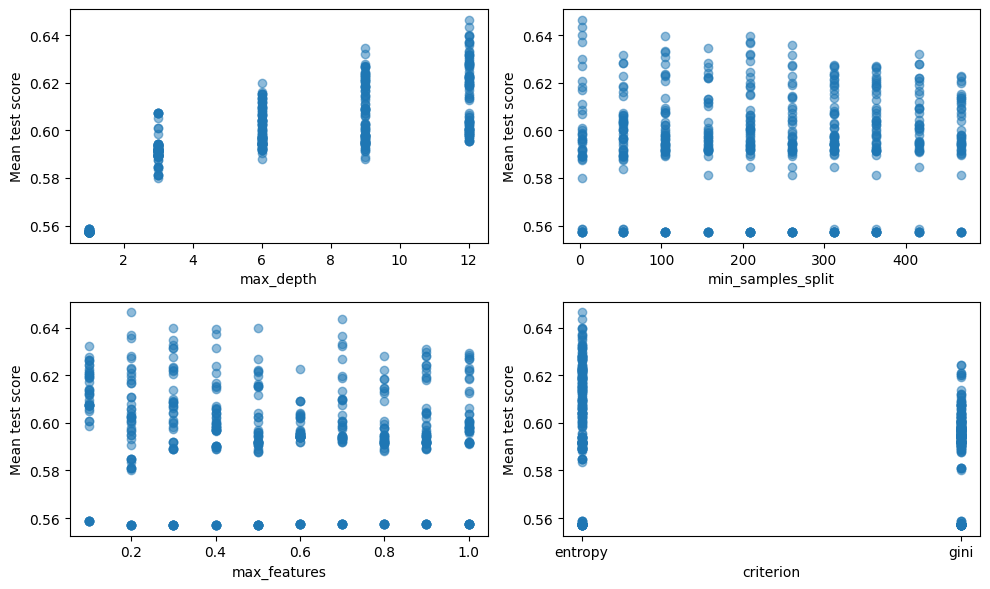

In [ ]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']


import seaborn as sns
for param_name in params[0].keys():
    # Extract the scores and hyperparameter values for the current parameter
    
    values = [pdict[param_name] for pdict in params]
    
    # Create a boxplot
    plt.figure()
    sns.boxplot(x=values, y=scores)
    plt.xlabel(param_name)
    plt.ylabel('f1_score')
    plt.show()

### Scoring

In [ ]:
# grid_search.best_params_
# hyperparam = {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}


hyperparam = {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}

In [ ]:
tuned_clf = DecisionTreeClassifier(
    random_state=random_state,
    **hyperparam, #grid_search.best_params_
)

In [ ]:
tuned_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, max_features=0.2,
                       random_state=1234)

In [ ]:
train_acc = tuned_clf.score(X_train, y_train)
print(f"Train accuracy score: {train_acc:.3f}")

# Evaluate the test accuracy
test_acc = tuned_clf.score(X_test, y_test)
print(f"Test accuracy score: {test_cc:.3f}")

Train accuracy score: 0.906
Test accuracy score: 0.863


In [ ]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)

In [ ]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

In [ ]:
train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")


train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

Train precision score: 0.938
Test precision score: 0.111
Train recall score: 0.379
Test recall score: 0.042


In [ ]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

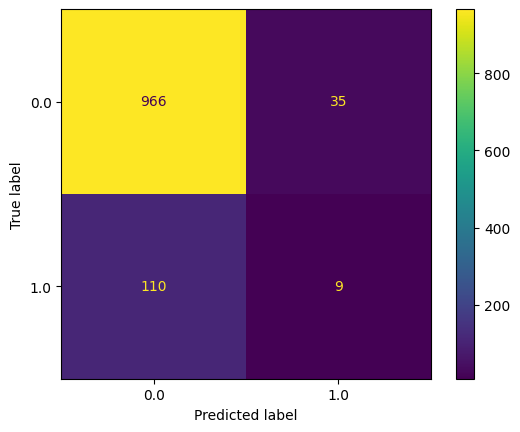

In [ ]:

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      3999
         1.0       0.96      0.44      0.60       681

    accuracy                           0.92      4680
   macro avg       0.93      0.72      0.78      4680
weighted avg       0.92      0.92      0.90      4680



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1001
           1       0.20      0.08      0.11       119

    accuracy                           0.87      1120
   macro avg       0.55      0.52      0.52      1120
weighted avg       0.82      0.87      0.84      1120



In [ ]:
from sklearn.metrics import f1_score
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 0.602
Test f1 score: 0.110


In [ ]:
# !pip install pydicom

# Image Classification with CNN

In [ ]:
import pandas as pd
# import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import tensorflow as tf
import os
import csv

from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from skimage import io, transform
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

2023-04-16 17:51:29.051711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 17:51:33.015097: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 17:51:44.134097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-16 17:51:44.134744: W tensorflow/strea

### Load Dataset

In [ ]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 13 s, sys: 950 ms, total: 14 s
Wall time: 14 s


In [ ]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [ ]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [ ]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [ ]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [ ]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [ ]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [ ]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [ ]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [ ]:
random_state = 1234

In [ ]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [ ]:
X= resized_images_mini
y = y_mini

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape

(4480, 224, 224, 1)

In [ ]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    return X_train_augm, y_train_augm

# Run the function
X_train_augm, y_train_augm = preprocess_augm(X_train, y_train)

2023-04-16 17:54:14.783987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-16 17:54:14.797954: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 17:54:14.798128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1866c7a4bea4): /proc/driver/nvidia/version does not exist
2023-04-16 17:54:14.872886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [ ]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

In [ ]:
X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=200)

In [ ]:
# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

In [ ]:
X_train.shape

(4680, 50176)

## Build Model

In [ ]:
param_grid = {
    'max_depth': [1, 3, 6, 9, 12], 
    'min_samples_split': np.linspace(2, .1 * len(X_train), 10).astype(int),
    'max_features': np.linspace(.1, 1, 10),
    'criterion': ['gini', 'entropy'],
}


In [ ]:
tune_clf = DecisionTreeClassifier(
    random_state=42
)

In [ ]:
X_train.shape

(4680, 50176)

In [ ]:
y_train.shape

(4680,)

In [ ]:
grid_search = RandomizedSearchCV(
    tune_clf, 
    param_distributions=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=20,
    n_iter=500,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 4/5; 3/500] START criterion=entropy, max_depth=3, max_features=0.8, min_samples_split=312
[CV 4/5; 3/500] END criterion=entropy, max_depth=3, max_features=0.8, min_samples_split=312;, score=(train=0.604, test=0.597) total time= 1.0min
[CV 5/5; 8/500] START criterion=gini, max_depth=3, max_features=0.1, min_samples_split=53
[CV 5/5; 8/500] END criterion=gini, max_depth=3, max_features=0.1, min_samples_split=53;, score=(train=0.609, test=0.630) total time=   6.0s
[CV 1/5; 10/500] START criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312
[CV 1/5; 10/500] END criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312;, score=(train=0.561, test=0.554) total time=  24.7s
[CV 2/5; 10/500] START criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312
[CV 2/5; 10/500] END criterion=entropy, max_depth=1, max_features=1.0, min_samples_split=312;, score=(train=0.559, test=0.554) tot

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 3, 6, 9, 12],
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'min_samples_split': array([  2,  53, 105, 157, 209, 260, 312, 364, 416, 468])},
                   return_train_score=True, scoring='roc_auc', verbose=20)

In [ ]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}
Best Score: 0.6464956576365987


In [ ]:
model_name = 'decisiontrees_augmented'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'results/{model_name}_crossvalidation_results.csv', index=False)

In [ ]:
# len(params)

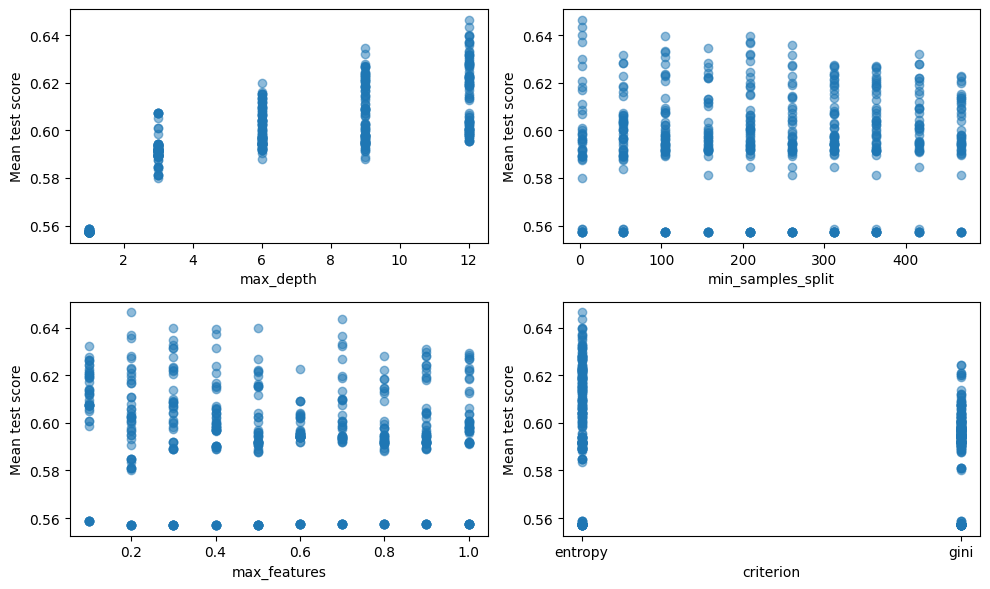

In [ ]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

# Plot the hyperparameters against their corresponding scores
plt.figure(figsize=(10, 6))
for i, param in enumerate(param_grid.keys()):
    plt.subplot(2, 2, i+1)
    plt.scatter([p[param] for p in params], scores, alpha=0.5)
    plt.xlabel(param)
    plt.ylabel('Mean test score')
plt.tight_layout()
plt.show()

### Scoring

In [ ]:
# grid_search.best_params_
# hyperparam = {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}


hyperparam = {'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 12, 'criterion': 'entropy'}

In [ ]:
tuned_clf = DecisionTreeClassifier(
    random_state=random_state,
    **hyperparam, #grid_search.best_params_
)

In [ ]:
tuned_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, max_features=0.2,
                       random_state=1234)

In [ ]:
train_acc = tuned_clf.score(X_train, y_train)
print(f"Train accuracy score: {train_acc:.3f}")

# Evaluate the test accuracy
test_cc = tuned_clf.score(X_test, y_test)
print(f"Test accuracy score: {test_cc:.3f}")

Train accuracy score: 0.906
Test accuracy score: 0.863


In [ ]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)

In [ ]:
train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")

Train precision score: 0.938
Test precision score: 0.111
Train recall score: 0.379
Test recall score: 0.042


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

In [ ]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

In [ ]:
from sklearn.metrics import f1_score
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 0.602
Test f1 score: 0.110


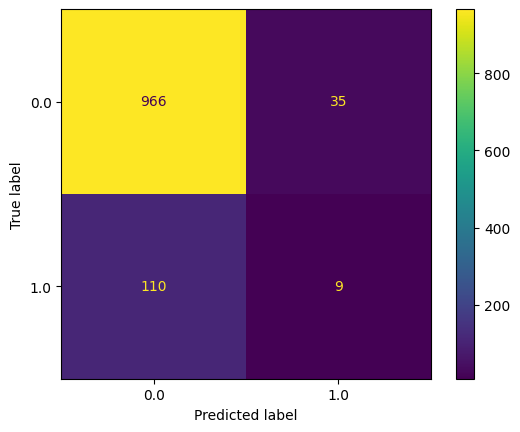

In [ ]:

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      3999
         1.0       0.96      0.44      0.60       681

    accuracy                           0.92      4680
   macro avg       0.93      0.72      0.78      4680
weighted avg       0.92      0.92      0.90      4680



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1001
           1       0.20      0.08      0.11       119

    accuracy                           0.87      1120
   macro avg       0.55      0.52      0.52      1120
weighted avg       0.82      0.87      0.84      1120

